# Imports

In [1]:
import os
from platypus import NSGAII, Problem, Real, nondominated_sort, SBX, PM, GAOperator, Evaluator, run_job, Archive, Solution
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import path
from shapely.geometry import Polygon, shape, Point
from descartes import PolygonPatch
import pylab as pl
from shapely import affinity
import random
import copy
from joblib import Parallel, delayed
import multiprocessing
from OSGridConverter import latlong2grid, grid2latlong
import matplotlib
import EMOVis

In [2]:
max_cores = multiprocessing.cpu_count()
print(max_cores)

12


In [3]:
os.chdir('C:/Users/zacha/Documents/GitHub/plymouth-university-proj518/data')
print(os.getcwd())

C:\Users\zacha\Documents\GitHub\plymouth-university-proj518\data


# OWF Problem

In [4]:
class OWF(Problem):
    def __init__(self, lon_limits, lat_limits, day_limits, data, map_polygon, wrecks_and_obstructions, shipping_density):
        """Locate optimal location (lat and long) in an area, to maximise
        Nvars: 11 (rotation of shape, lat/long center coordinates, 4 sets of lat/long offsets from center to define corners)
        """
        super(OWF, self).__init__(11, 5, 2)

        self.lat_limits = lat_limits
        self.lon_limits = lon_limits
        self.day_limits = day_limits

        self.data = data
        self.map_polygon = map_polygon
        self.wrecks_and_obstructions = wrecks_and_obstructions
        self.shipping_density = shipping_density

        #lat_range = lat_limits[1] - lat_limits[0]
        #lon_range = lon_limits[1] - lon_limits[0]

        # experimentally defined site size limitations
        #lat_range = lon_range = 0.007201325686340829
        #lon_range = 5.203365643890723e-07

        lat_range = 0.010353115110736666
        lon_range = 0.00611874675204227

        # only predict locations within the site boundaries
        # allow predictions to be Real numbers (i.e. floats)
        self.types = [
            # polygon is rotated by rotation angle
            Real(0, 360),

            # center of site
            Real(self.lon_limits[0], self.lon_limits[1]),  # center lat
            Real(self.lat_limits[0], self.lat_limits[1]),  # center lon

            # corners are offset from center coordinates

            Real(-lon_range, 0),    # q1 lon
            Real(0, lat_range),     # q1 lat
            
            Real(0, lon_range),     # q2 lon
            Real(0, lat_range),     # q2 lat

            Real(0, lon_range),     # q3 lon
            Real(-lat_range, 0),    # q3 lat

            Real(-lon_range, 0),    # q4 lon
            Real(-lat_range, 0),    # q4 lat
        ]

        self.directions = [
            Problem.MAXIMIZE,   # maximise Velocity Potential
            Problem.MINIMIZE,   # minimise area used
            Problem.MINIMIZE,   # minimise differential of mean velocity potential across days
            Problem.MINIMIZE,   # minimise shipping density at solution
            Problem.MINIMIZE,   # minimise wrecks and obstructions within solution
        ]

        self.constraints[:] = [
           "==100",  # constrain valid shapes to have >98% intersection with site boundary
           #"<0.8",    # constrain area of sites to be less than 0.8 (experimentally defined)
           ">-40",   # contrain depth of site to max. 40m (invert bc depth goes -inf -> 0)
           #">80",      # constrain proximity to avoid other solutions
        ]

        self.parameter_testing = {} # for storing parameters altered during testing and identifying solution ranks

    def evaluate(self, solution, verbose=False):
        """Evaluate variables of solution to determine fitness.

        Solution variables contain the following:
            rotation: rotation of the polygon about the center point.

            center_lat: latitude of the center point.
            center_lon: longitude of the center point.

            q1_lat: latitude of the first point of the quadrilateral.
            q1_lon: longitude of the first point of the quadrilateral.
            q2_lat: latitude of the second point of the quadrilateral.
            q2_lon: longitude of the second point of the quadrilateral.
            q3_lat: latitude of the third point of the quadrilateral.
            q3_lon: longitude of the third point of the quadrilateral.
            q4_lat: latitude of the fourth point of the quadrilateral.
            q4_lon: longitude of the fourth point of the quadrilateral.
        """

        x = solution.variables[:]

        # read solution into variables
        rotation = x[0]
        center = x[1:3]
        q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
        
        # calculate corner coordinates from center and q offset
        q1_coord = [center[0] + q1[0], center[1] + q1[1]]
        q2_coord = [center[0] + q2[0], center[1] + q2[1]]
        q3_coord = [center[0] + q3[0], center[1] + q3[1]]
        q4_coord = [center[0] + q4[0], center[1] + q4[1]]

        # rotation corner coordinates by rotation angle
        points = np.array([q1_coord, q2_coord, q3_coord, q4_coord])
        polygon = path.Path(points)

        # get bathymetryic and velocity potential data within polygon
        data_polygon = self.data[
            polygon.contains_points(self.data[["Lon", "Lat"]].values)
        ]

        # dataframe is empty, because no data at that location (out of bounds / too small)
        if data_polygon.empty:
            # make fitness infinitely bad
            area = np.inf
            depth = -np.inf
            velocity_potential_mean = -np.inf
            velocity_potential_stability = np.inf
            shipping_density = np.inf
            wrecks_and_obstructions = np.inf
            intersection = -np.inf

        else:
            # get all wrecks and obstructions within polygon
            wrecks_and_obstructions = self.wrecks_and_obstructions[
                polygon.contains_points(self.wrecks_and_obstructions[["longitude", "latitude"]].values)
            ]
            # fitness is number of wrecks or obstructions inside polygon (less is better)
            wrecks_and_obstructions = len(wrecks_and_obstructions)

            # get shipping density by locating density polygon which contains center point
            shipping_density = np.inf
            for i, row in self.shipping_density.iterrows():
                # test if center is within row['polygon']
                if row['polygon'].contains_point(center):
                    shipping_density = row['yearly_avg']
                    break

            # calculate mean Velocity Potential
            
            velocity_potential = data_polygon.drop(['Lon', 'Lat', 'Depth'], axis=1)

            velocity_potential_stability = velocity_potential.std(axis=1).mean()

            velocity_potential_mean = velocity_potential.mean(axis=1).mean()
            
            # calculate intersection of polygon with map polygon
            shapely_polygon = Polygon(points).buffer(0)

            # rotate polygon by rotation angle about center coordinate
            shapely_polygon = affinity.rotate(shapely_polygon, rotation, origin=center)

            # calculate intersection area between map polygon and solution polygon
            intersection = self.map_polygon.intersection(shapely_polygon).area
            intersection = intersection / shapely_polygon.area * 100.0

            # scale area of polygon
            area = shapely_polygon.area * 100.0

            # get max depth from bathymetric data polygon
            # with contraints, ensure turbines can be placed in any section of area
            # NOTE: if problems finding solutions - revert to mean depth, ensuring dominant % of polygon is viable regarding depth
            depth = data_polygon["Depth"].max()

        solution.objectives[:] = [
            velocity_potential_mean,
            area,
            velocity_potential_stability,
            shipping_density,
            wrecks_and_obstructions,
        ]
        
        solution.constraints[:] = [
            intersection,
            depth,
        ]


## Custom Variator

* The default SBX Variator applies crossover to all decision variables in the solution.
* As the decision variables of our solution are spatial, meaning solutions for one location may not apply well to another, crossover at a high rate only results in solution covergence in the search space.
* To reduce this, we experiment with reducing probability of crossover between solutions for all or specific decision variables.

In [5]:
class CustomSBX(SBX):
    def __init__(self, apply_crossover=1.0, crossover_centre=1.0, crossover_others=1.0):
        super(CustomSBX, self).__init__()
        self.apply_crossover = apply_crossover
        self.crossover_centre = crossover_centre
        self.crossover_others = crossover_others

    def evolve(self, parents):
        child1 = copy.deepcopy(parents[0])
        child2 = copy.deepcopy(parents[1])
        
        if random.uniform(0.0, 1.0) <= self.apply_crossover:
            problem = child1.problem
            nvars = problem.nvars
            
            for i in range(nvars):
                if isinstance(problem.types[i], Real):
                    if ((i == 1 or i == 2) and random.uniform(0.0, 1.0) <= self.crossover_centre) or ((i != 1 and i != 2) and random.uniform(0.0, 1.0) <= self.crossover_others):
                        x1 = float(child1.variables[i])
                        x2 = float(child2.variables[i])
                        lb = problem.types[i].min_value
                        ub = problem.types[i].max_value
                        
                        x1, x2 = self.sbx_crossover(x1, x2, lb, ub)
                        
                        child1.variables[i] = x1
                        child2.variables[i] = x2
                        child1.evaluated = False
                        child2.evaluated = False
                    
        return [child1, child2]

## Multiprocessing evaluator

* Solutions can be evaluated independently, enabling parallelization on multi-core processors.
* By splitting computationally intensive task amongst cores, speed-up can be achieved.
* We augmented the MapEvaluator function (default evaluator applied to solutions) with multiprocessing to achieve this.

In [6]:
class MultiprocessingMapEvaluator(Evaluator):
    
    def __init__(self, num_cores, map_func=map):
        super(MultiprocessingMapEvaluator, self).__init__()
        self.map_func = map_func
        self.num_cores = num_cores

    def _chunks(self, items, n):
        result = []
        iterator = iter(items)
        
        try:
            while True:
                result.append(next(iterator))
                
                if len(result) == n:
                    yield result
                    result = []
        except StopIteration:
            if len(result) > 0:
                yield result
    
    def evaluate_job(self, chunk):
        return self.map_func(run_job, chunk)
    
    def evaluate_all(self, jobs, **kwargs):
        log_frequency = kwargs.get("log_frequency", None)
        
        if log_frequency is None:
            results = Parallel(n_jobs=self.num_cores)(delayed(run_job)(job) for job in jobs)

        else:
            results = Parallel(n_jobs=self.num_cores)(delayed(self.evaluate_job)(chunk) for chunk in self._chunks(jobs, log_frequency))

        return results

# Data

## Uk east coast velocity potential and bathymetry data

In [7]:
data = pd.read_csv("UK east coast velocity potential bathymetry.csv")

# NOTE: experimentally defined, enclosing area of map with depth >40m
lat_range = (53.486257927, 54.1)
lon_range = (0.5, 2.5571098)
days_range = (0, 228)

print(f"Latitude range: {lat_range}, Longitude range: {lon_range}")

print(data.head())

Latitude range: (53.486257927, 54.1), Longitude range: (0.5, 2.5571098)
        Lon        Lat          0          1          2          3          4  \
0  0.908810  53.508833 -4888854.5 -2964274.8 -1966400.0 -1944809.2 -322963.75   
1  0.982291  53.615490 -4988734.5 -3007930.2 -2047237.6 -2029393.5 -354367.40   
2  0.827796  53.586244 -4784387.0 -2952906.5 -1962346.2 -1973532.0 -356079.72   
3  0.837720  53.702704 -4801098.0 -2978041.2 -2017788.0 -2047978.2 -395331.00   
4  1.000396  53.708305 -5014005.5 -3031230.2 -2096183.8 -2092127.0 -384673.72   

           5          6          7  ...        220        221        222  \
0  1918140.2  2201700.2  497169.94  ...  3623697.0  3458370.5  3322026.8   
1  1893077.1  2230719.8  457650.47  ...  3645998.0  3475556.8  3341163.8   
2  1899125.8  2204834.5  470712.70  ...  3644461.0  3473458.5  3349537.8   
3  1871085.8  2224391.5  432494.90  ...  3669871.5  3497450.5  3374911.8   
4  1869927.0  2249043.0  425658.60  ...  3665922.8  3491546.0

## UK east coast edge points alpha 17.5 data

In [8]:
# read map polygon coords and create polygon
polygon_df = pd.read_csv("UK east coast edge points alpha 17.5.csv")
polygon_np = polygon_df.to_numpy()

map_polygon = Polygon(polygon_np)


## UK east coast wrecks and obstructions

In [9]:
wrecks_and_obstructions = pd.read_csv("UK east coast wrecks and obstructions.csv")

## UK east coast shipping density (2015)

In [10]:
shipping_density = pd.read_csv("UK east coast shipping density 2015.csv")

shipping_density['polygon'] = shipping_density['polygon'].apply(lambda x: path.Path(eval(x)))

# Optimisation

In [11]:
# load the problem
problem = OWF(
    lat_limits=lat_range,
    lon_limits=lon_range,
    day_limits=days_range,
    data=data,
    map_polygon=map_polygon,
    wrecks_and_obstructions=wrecks_and_obstructions,
    shipping_density=shipping_density,
)

In [12]:
algorithm = NSGAII(problem, population_size=200, variator=GAOperator(CustomSBX(), PM()))
algorithm.run(10000)

In [13]:
# get feasible and nondominated solutions
feasible_solutions = [s for s in algorithm.result if s.feasible]
print(f"Feasible solutions: {len(feasible_solutions)}")

nondominated_sort(feasible_solutions)   # rank feasible solutions

# convert results to pandas dataframe
results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
        "Velocity Potential",
        "Area",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "Rank",
    ]
)

# read nondominated solutions into dataframe
for i, solution in enumerate(feasible_solutions):
    results.loc[i] = [*solution.variables[:], *solution.objectives, solution.rank]

print(f"Ranks: {len(set(results['Rank']))}, Nondominated: {len(results.loc[results['Rank'] == 0])}")


Feasible solutions: 200
Ranks: 1, Nondominated: 200


# Visualisation


## 6D function

In [14]:
def multidimensional6(r):
    # Visualizing 6-D mix data using bubble charts
    # leveraging the concepts of hue, size, depth and shape

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    t = fig.suptitle('Velocity potential - Stability - Area - Shipping density - Wrecks and obstructions')

    # calculate min and max values for Area
    rmin, rmax = r['Area'].min(), r['Area'].max()
    # calculate step size for Area
    rdiff = rmax - rmin if rmax > rmin else 1
    sizing = ((r['Area'] - rmin) / rdiff) * 100  # calculate size as a percentage of max size, then scale to become a useful size in the plot
    
    for idx, row in r.iterrows():
        ax.scatter(row['Stability'], row['Shipping Density'], row['Wrecks and Obstructions'], alpha=0.4, c=row['Velocity Potential'], cmap='viridis', edgecolors='none', s=sizing[idx], marker=row['Marker'])

    ax.set_xlabel('Stability (mean deviation of Velocity Potential/year)')
    ax.set_ylabel('Shipping Density (mean shipping activity/week)')
    ax.set_zlabel('Wrecks and Obstructions (total wrecks / obstructions in solution space)')

    fig.text(.5, .05, 'Area (size of point is relative area of solution)', ha='center')

    # add a legend indicating the depth of each point
    cmap = matplotlib.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=r['Velocity Potential'].min(), vmax=r['Velocity Potential'].max())
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    cbar.set_label('Velocity Potential (mean potential/year)')

    plt.show()

## 5D function

In [15]:
def multidimensional5(r):
    # Visualizing 5-D mix data using bubble charts
    # leveraging the concepts of hue, size and depth
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    t = fig.suptitle('Velocity potential - Stability - Area - Shipping density - Wrecks and obstructions')

    # calculate min and max values for Area
    rmin, rmax = r['Area'].min(), r['Area'].max()
    # calculate step size for Area, catch 0 size diff by scaling by 1
    rdiff = rmax - rmin if rmax > rmin else 1
    sizing = ((r['Area'] - rmin) / rdiff) * 100  # calculate size as a percentage of max size, then scale to become a useful size in the plot

    colormap = ax.scatter(r['Stability'], r['Shipping Density'], r['Wrecks and Obstructions'], alpha=0.4, c=r['Velocity Potential'], cmap='viridis', edgecolors='none', s=sizing)

    ax.set_xlabel('Stability (mean deviation of Velocity Potential/year)')
    ax.set_ylabel('Shipping Density (mean shipping activity/week)')
    ax.set_zlabel('Wrecks and Obstructions (total wrecks / obstructions in solution space)')

    fig.text(.5, .05, 'Area (size of point is relative area of solution)', ha='center')

    # add a legend indicating the depth of each point
    cbar = fig.colorbar(colormap, ax=ax)
    cbar.set_label('Velocity Potential (mean potential/year)')

    plt.show()

## 4D function

In [16]:
def multidimensional4(r):
    # Visualizing 5-D mix data using bubble charts
    # leveraging the concepts of hue, size and depth
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    t = fig.suptitle('Velocity potential - Stability - Area - Shipping density - Wrecks and obstructions')

    colormap = ax.scatter(r['Stability'], r['Shipping Density'], r['Wrecks and Obstructions'], alpha=0.4, c=r['Velocity Potential'], cmap='viridis', edgecolors='none')

    ax.set_xlabel('Stability (mean deviation of Velocity Potential/year)')
    ax.set_ylabel('Shipping Density (mean shipping activity/week)')
    ax.set_zlabel('Wrecks and Obstructions (total wrecks / obstructions in solution space)')

    # add a legend indicating the depth of each point
    cbar = fig.colorbar(colormap, ax=ax)
    cbar.set_label('Velocity Potential (mean potential/year)')

    plt.show()

## Pareto front

### 5-D nondominated front visualisation

In [17]:
results

,rotation,center_lon,center_lat,q1_lon,q1_lat,q2_lon,q2_lat,q3_lon,q3_lat,q4_lon,q4_lat,Velocity Potential,Area,Stability,Shipping Density,Wrecks and Obstructions,Rank
0,119.716049,2.088327,53.545424,-0.000558,0.000706,0.001578,0.000912,0.000629,-0.010289,-0.000959,-0.006122,2.667534e+06,0.001812,2.803305e+06,156.000000,0.0,0.0
1,227.448453,2.524777,53.627065,-0.000415,0.000966,0.005731,0.003027,0.000442,-0.000149,-0.000009,-0.002381,2.639888e+06,0.000552,2.798174e+06,125.666667,0.0,0.0
2,200.225126,2.540671,53.539687,-0.000334,0.001337,0.000033,0.004046,0.000487,-0.003628,-0.000479,-0.004914,2.646993e+06,0.000495,2.796905e+06,255.666667,0.0,0.0
3,69.303977,0.704521,53.504818,-0.005878,0.001123,0.000949,0.000355,0.000275,-0.005826,-0.000858,-0.009841,2.751269e+06,0.003765,2.818126e+06,788.666665,0.0,0.0
4,141.576682,1.068661,53.503640,-0.000002,0.000588,0.000175,0.000124,0.000281,-0.005920,-0.000242,-0.007741,2.727496e+06,0.000247,2.816618e+06,78.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,141.296230,2.481367,53.544641,-0.001309,0.000663,0.002780,0.004324,0.001209,-0.000838,-0.000415,-0.007723,2.648868e+06,0.001756,2.797643e+06,255.666667,0.0,0.0
196,140.510107,2.229597,53.545911,-0.000227,0.000578,0.001280,0.000888,0.000656,-0.010259,-0.002389,-0.006687,2.660510e+06,0.002322,2.801277e+06,156.000000,0.0,0.0
197,172.873499,1.739984,53.740480,-0.000235,0.000745,0.001533,0.001796,0.000697,-0.000534,-0.000603,-0.003082,2.666969e+06,0.000364,2.810645e+06,645.666667,0.0,0.0
198,120.366330,2.499368,53.539565,-0.000556,0.001055,0.005185,0.003966,0.002309,-0.004921,-0.002685,-0.006149,2.648596e+06,0.003801,2.797409e+06,212.333333,0.0,0.0


(200, 17)
       rotation  center_lon  center_lat    q1_lon    q1_lat    q2_lon  \
0    119.716049    2.088327   53.545424 -0.000558  0.000706  0.001578   
1    227.448453    2.524777   53.627065 -0.000415  0.000966  0.005731   
2    200.225126    2.540671   53.539687 -0.000334  0.001337  0.000033   
3     69.303977    0.704521   53.504818 -0.005878  0.001123  0.000949   
4    141.576682    1.068661   53.503640 -0.000002  0.000588  0.000175   
..          ...         ...         ...       ...       ...       ...   
195  141.296230    2.481367   53.544641 -0.001309  0.000663  0.002780   
196  140.510107    2.229597   53.545911 -0.000227  0.000578  0.001280   
197  172.873499    1.739984   53.740480 -0.000235  0.000745  0.001533   
198  120.366330    2.499368   53.539565 -0.000556  0.001055  0.005185   
199  158.311762    1.511234   53.736064 -0.000328  0.000923  0.000972   

       q2_lat    q3_lon    q3_lat    q4_lon    q4_lat  Velocity Potential  \
0    0.000912  0.000629 -0.010289 -0

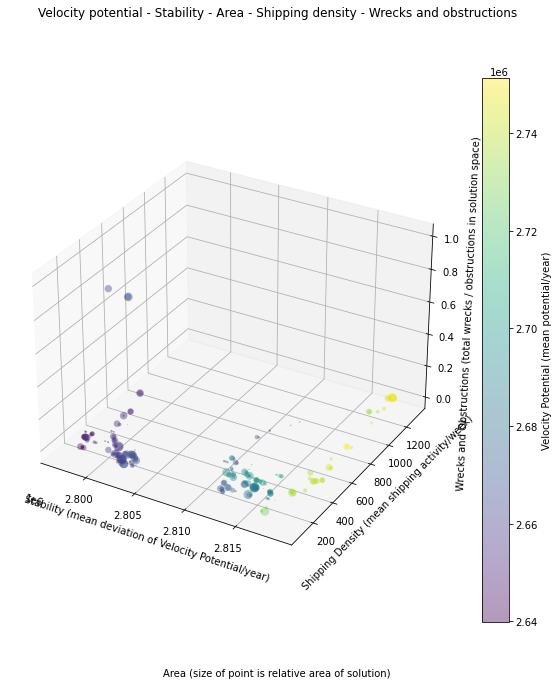

In [18]:
r = results[results['Rank'] == 0.0]
print(r.shape)

print(r)

multidimensional5(r)

### All solutions

(200, 17)


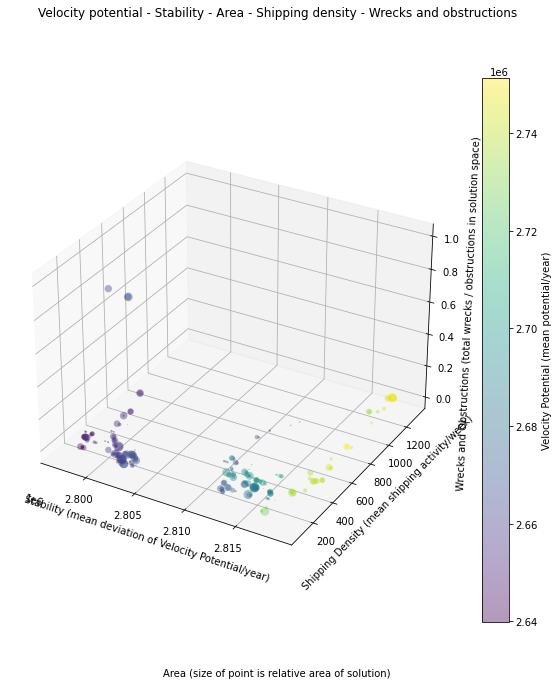

In [19]:
print(results.shape)

multidimensional5(results)

## Solution visualisation

In [20]:
file = 'UKHO ADMIRALTY bathymetry UK east coast.csv'
admiralty_df = pd.read_csv(file, sep=',')
admiralty_df = admiralty_df[admiralty_df['Depth'] > -40]

### All solutions

c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


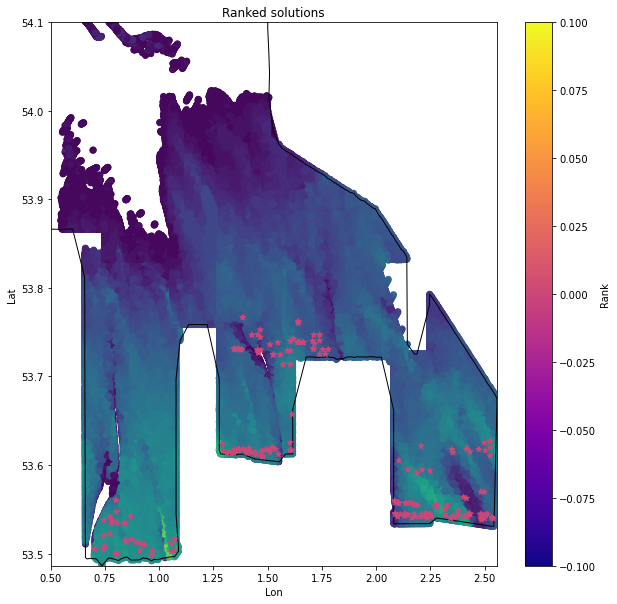

In [21]:
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Ranked solutions")

# load depth scatter into plot and reuse
ax.scatter(admiralty_df["Lon"], admiralty_df["Lat"], c=admiralty_df["Depth"], cmap="viridis")

ax.set_xlabel("Lon")
ax.set_ylabel("Lat")

map_patch = PolygonPatch(map_polygon, fc="#999999", ec="#000000", fill=False)
ax.add_patch(map_patch)

map = ax.scatter(results['center_lon'], results['center_lat'], c=results['Rank'], cmap='plasma', marker="*")

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Rank')

plt.show()


### Nondominated solutions vs. existing sites


In [22]:
nondominated_solutions = results.loc[results['Rank'] == 0.0]

In [23]:
file = 'UK east coast wind energy locations.csv'
df = pd.read_csv(file, sep=',')

known_solutions = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
    ]
)


for idx, row in df.iterrows():
    lon, lat, turbnum = row['LNG'], row['LAT'], row['TURBNUM']

    grid = latlong2grid(lat, lon)
    easting, northing = grid.eastNorth()

    # square root turbnum to get number of turbines along lon / lat dimensions
    length_turbnum = np.sqrt(turbnum)

    # length of lon / lat dimensions from 500m radius / turbine in metres
    # get offset from 500m / 2.0 for radius, then divide by 10.0 to get northing/eassting conversion to 10x10m national grid = 25.0
    eastNorth_offset = int(length_turbnum * 25.0)

    print(eastNorth_offset)

    # calculate easting northings of corners
    q1_easting, q1_northing = easting - eastNorth_offset, northing + eastNorth_offset
    q2_easting, q2_northing = easting + eastNorth_offset, northing + eastNorth_offset
    q3_easting, q3_northing = easting - eastNorth_offset, northing - eastNorth_offset
    q4_easting, q4_northing = easting + eastNorth_offset, northing - eastNorth_offset

    # calculate lons and lats of corners
    q1 = grid2latlong(f'TB {str(q1_easting)[1:]} {str(q1_northing)[1:]}', tag='WGS84')
    q2 = grid2latlong(f'TB {str(q2_easting)[1:]} {str(q2_northing)[1:]}', tag='WGS84')
    q3 = grid2latlong(f'TB {str(q3_easting)[1:]} {str(q3_northing)[1:]}', tag='WGS84')
    q4 = grid2latlong(f'TB {str(q4_easting)[1:]} {str(q4_northing)[1:]}', tag='WGS84')

    q1_lon, q1_lat = q1.longitude, q1.latitude
    q2_lon, q2_lat = q2.longitude, q2.latitude
    q3_lon, q3_lat = q3.longitude, q3.latitude
    q4_lon, q4_lat = q4.longitude, q4.latitude

    # calculate offsets from centre
    q1_lon_offset = q1_lon - lon
    q1_lat_offset = q1_lat - lat
    q2_lon_offset = q2_lon - lon
    q2_lat_offset = q2_lat - lat
    q3_lon_offset = q3_lon - lon
    q3_lat_offset = q3_lat - lat
    q4_lon_offset = q4_lon - lon
    q4_lat_offset = q4_lat - lat

    known_solutions.loc[len(known_solutions.index)] = [0, lon, lat, q1_lon_offset, q1_lat_offset, q2_lon_offset, q2_lat_offset, q4_lon_offset, q4_lat_offset, q3_lon_offset, q3_lat_offset]

print(known_solutions)

379
335
321
329
   rotation  center_lon  center_lat    q1_lon    q1_lat    q2_lon    q2_lat  \
0       0.0    1.422626   53.681258 -0.002251  0.003563  0.009238  0.003235   
1       0.0    1.422626   53.681258 -0.001616  0.003149  0.008539  0.002860   
2       0.0    1.541901   53.959745 -0.001086  0.003026  0.008710  0.002737   
3       0.0    1.422626   53.681258 -0.001530  0.003093  0.008443  0.002808   

     q3_lon    q3_lat    q4_lon    q4_lat  
0  0.008683 -0.003566 -0.002804 -0.003238  
1  0.008048 -0.003152 -0.002105 -0.002862  
2  0.008219 -0.003022 -0.001576 -0.002733  
3  0.007962 -0.003095 -0.002010 -0.002811  


#### Plot

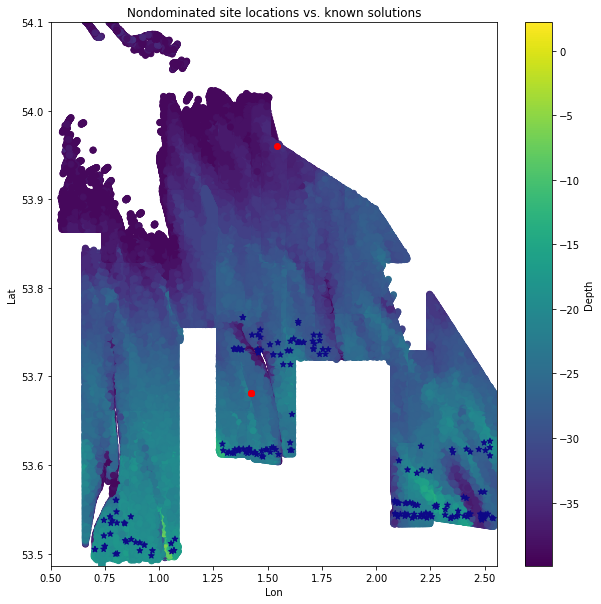

In [24]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site locations vs. known solutions")

map = ax.scatter(admiralty_df['Lon'], admiralty_df['Lat'], c=admiralty_df['Depth'], cmap='viridis')

ax.scatter(known_solutions['center_lon'], known_solutions['center_lat'], c="r", marker="o")

ax.scatter(nondominated_solutions['center_lon'], nondominated_solutions['center_lat'], c=nondominated_solutions['Rank'], cmap='plasma', marker="*")

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

pl.show()

#### Plot

c:\Users\zacha\miniconda3\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
c:\Users\zacha\miniconda3\lib\site-packages\shapely\affinity.py:109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if origin == 'center':
c:\Users\zacha\miniconda3\lib\site-packages\shapely\affinity.py:113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif origin == 'centroid':


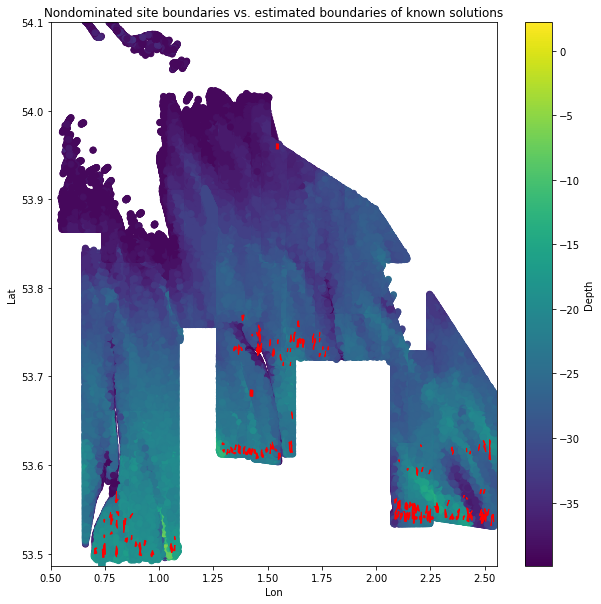

In [25]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site boundaries vs. estimated boundaries of known solutions")

map = ax.scatter(admiralty_df['Lon'], admiralty_df['Lat'], c=admiralty_df['Depth'], cmap='viridis')

# construct polygons from quads
for idx, row in known_solutions.iterrows():
    x = row.to_numpy()

    rotation = x[0]
    center = x[1:3]
    q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]
    
    # calculate corner coordinates from center and q offset
    q1_coord = [center[0] + q1[0], center[1] + q1[1]]
    q2_coord = [center[0] + q2[0], center[1] + q2[1]]
    q3_coord = [center[0] + q3[0], center[1] + q3[1]]
    q4_coord = [center[0] + q4[0], center[1] + q4[1]]

    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

    polygon = Polygon(p)

    patch = PolygonPatch(polygon, fc="#FF0000", ec="#FF0000", fill=True)
    ax.add_patch(patch)

for i in range(0, nondominated_solutions.shape[0]):
    x = nondominated_solutions.loc[i]

    x = x.to_numpy()

    # read solution into variables
    rotation = x[0]
    center = x[1:3]
    q1, q2, q3, q4 = x[3:5], x[5:7], x[7:9], x[9:11]

    # calculate corner coordinates from center and q offset
    # REVERSE XY from LAT LON to LON LAT
    q1_coord = [center[0] + q1[0], center[1] + q1[1]]
    q2_coord = [center[0] + q2[0], center[1] + q2[1]]
    q3_coord = [center[0] + q3[0], center[1] + q3[1]]
    q4_coord = [center[0] + q4[0], center[1] + q4[1]]

    # rotation corner coordinates by rotation angle
    p = np.array([q1_coord, q2_coord, q3_coord, q4_coord])

    polygon = Polygon(p)
    # rotate polygon by rotation angle about center coordinate
    polygon = affinity.rotate(polygon, rotation, origin=center)
    
    patch = PolygonPatch(polygon, fc="#FF0000", ec="#FF0000", fill=True)
    ax.add_patch(patch)

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)


# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

pl.show()

### Existing site evaluation

In [26]:
# generate solution objects for known locations
existing_solutions = []

for idx, row in known_solutions.iterrows():
    sol = Solution(problem)
    sol.variables[:] = list(known_solutions.loc[idx])
    problem.evaluate(sol, verbose=True) # update objectives and constraints fitness

    setattr(sol, 'is_known', True)  # mark solution as known solution

    existing_solutions.append(sol)

print(existing_solutions)

[Solution[0.0,1.422626,53.681258,-0.0022510750232094257,0.003562981395539566,0.009237626363861828,0.0032352429119058,0.008682818724077501,-0.0035655584701004273,-0.0028040248064982176,-0.0032379009983429796|2689388.6475461386,0.007830802907079982,2814065.1466958043,949.0,0|0.0], Solution[0.0,1.422626,53.681258,-0.0016162942475881348,0.0031492133327049032,0.00853853116158576,0.002859527800858075,0.008048229232271886,-0.003151738797555481,-0.0021051446557847076,-0.002862116559285255|2689376.6717574126,0.006118112903863764,2814062.689073699,949.0,0|0.0], Solution[0.0,1.541901,53.959745,-0.0010860460275041728,0.0030257220191671763,0.008709952448183289,0.0027374735309564358,0.008218741575890531,-0.0030215769387069713,-0.001575901258393575,-0.00273338897697073|2659545.744610511,0.005655342302213288,2815954.503458837,190.6666667,0|0.0], Solution[0.0,1.422626,53.681258,-0.0015297341462945369,0.003092790168558679,0.008443201024719516,0.0028082935909594653,0.0079616933885156,-0.00309530908852906

In [27]:
archive = Archive()

# add to archive
archive.extend(feasible_solutions)
archive.extend(existing_solutions)

In [28]:
# convert into list of solutions for plotting
combined_results = pd.DataFrame(
    columns=[
        "rotation",
        "center_lon",
        "center_lat",
        "q1_lon",
        "q1_lat",
        "q2_lon",
        "q2_lat",
        "q3_lon",
        "q3_lat",
        "q4_lon",
        "q4_lat",
        "Velocity Potential",
        "Area",
        "Stability",
        "Shipping Density",
        "Wrecks and Obstructions",
        "Marker",
    ]
)

markers = ["o", "v", "^", ">", "<", "s", "p", "P", "*", "h", "H", "D", "d", "X", "x", "1", "2", "3", "4", "8"]

# read nondominated solutions into dataframe
for i, solution in enumerate(archive):
    if hasattr(solution, 'is_known'):
        mark = markers[0]
    else:
        mark = markers[1]

    combined_results.loc[i] = [*solution.variables, *solution.objectives, mark]

# remove solutions with an invalid value
combined_results.replace([np.inf, -np.inf], np.nan, inplace=True)
combined_results.dropna(inplace=True)

print(combined_results)

       rotation  center_lon  center_lat    q1_lon    q1_lat    q2_lon  \
0    119.716049    2.088327   53.545424 -0.000558  0.000706  0.001578   
1    227.448453    2.524777   53.627065 -0.000415  0.000966  0.005731   
2    200.225126    2.540671   53.539687 -0.000334  0.001337  0.000033   
3     69.303977    0.704521   53.504818 -0.005878  0.001123  0.000949   
4    141.576682    1.068661   53.503640 -0.000002  0.000588  0.000175   
..          ...         ...         ...       ...       ...       ...   
195  141.296230    2.481367   53.544641 -0.001309  0.000663  0.002780   
196  140.510107    2.229597   53.545911 -0.000227  0.000578  0.001280   
197  172.873499    1.739984   53.740480 -0.000235  0.000745  0.001533   
198  120.366330    2.499368   53.539565 -0.000556  0.001055  0.005185   
199  158.311762    1.511234   53.736064 -0.000328  0.000923  0.000972   

       q2_lat    q3_lon    q3_lat    q4_lon    q4_lat  Velocity Potential  \
0    0.000912  0.000629 -0.010289 -0.000959 -0

#### Plot

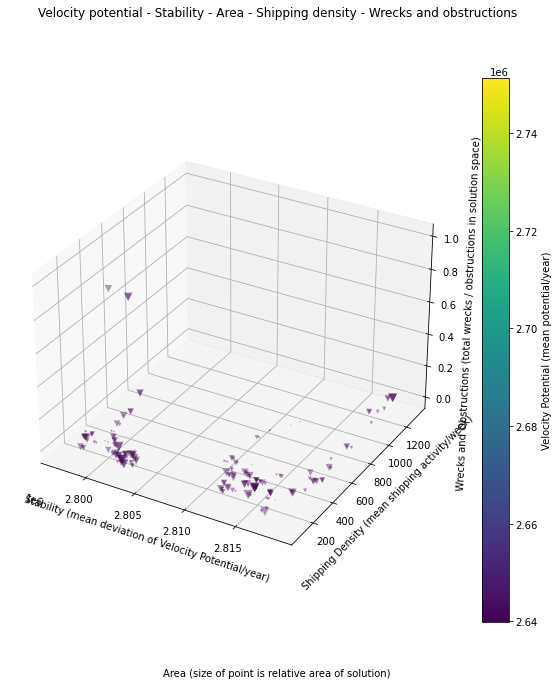

In [29]:
multidimensional6(combined_results)  # 6D visualization - 5 objectives + distinguishing between known and predicted solutions

(200, 17)


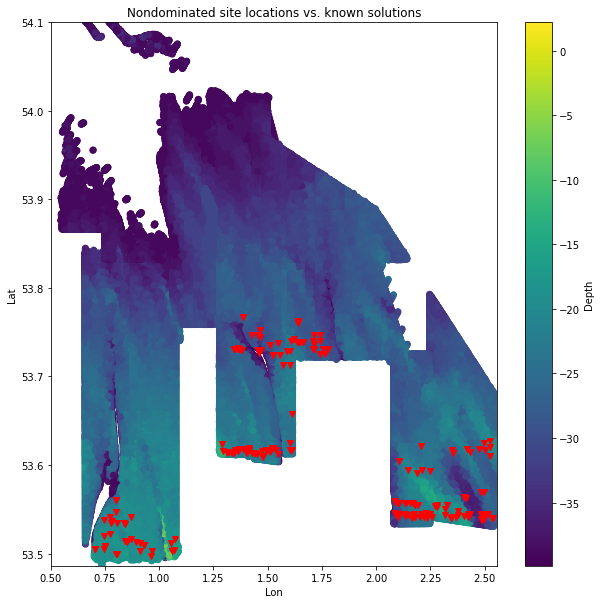

In [30]:
# plot contrained to search space
fig = pl.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

ax.set_title("Nondominated site locations vs. known solutions")

map = ax.scatter(admiralty_df['Lon'], admiralty_df['Lat'], c=admiralty_df['Depth'], cmap='viridis')

print(combined_results.shape)
for idx, row in combined_results.iterrows():
    ax.scatter(row['center_lon'], row['center_lat'], c='red', marker=row['Marker'])

ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

# set axis limits to viable area
ax.set_xlim(lon_range)
ax.set_ylim(lat_range)

# add a legend indicating the depth of each point
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Depth')

pl.show()

## EMOVis

In [31]:
def unpack_platypus(solutions):
    """
    Take the Pareto front approximation from a Platypus optimiser and
    return a tuple of Numpy arrays -- one holds the decision variables and
    the other hold the objective variables.
    """
    X = np.array([soln.variables for soln in solutions])
    Y = np.array([soln.objectives for soln in solutions])
    return X, Y

[[ 1.19716049e+02  2.08832732e+00  5.35454236e+01 ... -1.02886390e-02
  -9.59335180e-04 -6.12189312e-03]
 [ 2.27448453e+02  2.52477660e+00  5.36270646e+01 ... -1.48900507e-04
  -9.09707027e-06 -2.38054295e-03]
 [ 2.00225126e+02  2.54067126e+00  5.35396870e+01 ... -3.62802348e-03
  -4.78604745e-04 -4.91354347e-03]
 ...
 [ 1.72873499e+02  1.73998431e+00  5.37404802e+01 ... -5.33623373e-04
  -6.02712658e-04 -3.08195737e-03]
 [ 1.20366330e+02  2.49936777e+00  5.35395649e+01 ... -4.92129082e-03
  -2.68486184e-03 -6.14946991e-03]
 [ 1.58311762e+02  1.51123421e+00  5.37360641e+01 ... -5.69253507e-03
  -2.09345742e-04 -2.58009801e-03]] [[2.66753393e+06 1.81230381e-03 2.80330532e+06 1.56000000e+02
  0.00000000e+00]
 [2.63988758e+06 5.51825189e-04 2.79817416e+06 1.25666667e+02
  0.00000000e+00]
 [2.64699264e+06 4.94655089e-04 2.79690504e+06 2.55666667e+02
  0.00000000e+00]
 [2.75126906e+06 3.76467745e-03 2.81812638e+06 7.88666665e+02
  0.00000000e+00]
 [2.72749605e+06 2.46879759e-04 2.81661822e+

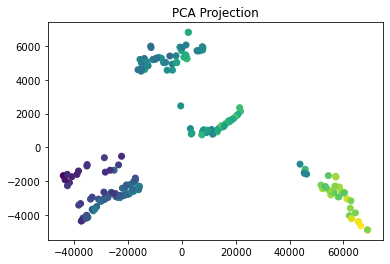

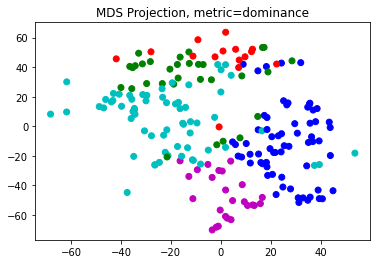

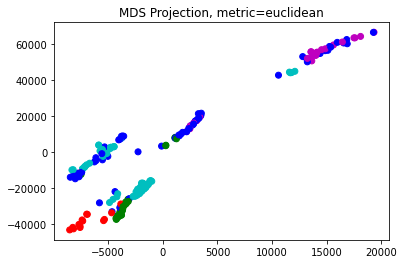

In [32]:
# Produce a parallel coordinate plot.
X, Y = unpack_platypus(feasible_solutions)

print(X, Y)

r = EMOVis.rank_best_obj(Y)
cols = ["rbgcmyk"[c] for c in r]
#vis.parallel_coords(Y, cols)

# Produce a PCA projection.
r = EMOVis.average_rank(Y) / Y.shape[0]
EMOVis.pca_projection(Y, colours=r)

# Produce a dominance-distance MDS projection.
EMOVis.mds_projection(Y, metric="dominance", colours=cols)
EMOVis.mds_projection(Y, metric="euclidean", colours=cols)

# Show the visualisations.
plt.show()